### 定义函数

In [1]:
# load model

device = 'cuda'
resnet_layers = 18
with_pretrain = True

import models
import torch

def load_model(poseNetPath,dispNetPath):
    # create model
    print("=> creating model")
    disp_net = models.DispResNet(resnet_layers, with_pretrain).to(device)
    pose_net = models.PoseResNet(18, with_pretrain).to(device)

    # load weight
    print("=> load weight")
    weights = torch.load(poseNetPath)
    pose_net.load_state_dict(weights['state_dict'], strict=False)
    weights = torch.load(dispNetPath)
    disp_net.load_state_dict(weights['state_dict'], strict=False)

    disp_net = torch.nn.DataParallel(disp_net)
    pose_net = torch.nn.DataParallel(pose_net)
    
    return disp_net,pose_net

def load_dispNet(dispNetPath):
    disp_net = models.DispResNet(resnet_layers, with_pretrain).to(device)
    weights = torch.load(dispNetPath)
    disp_net.load_state_dict(weights['state_dict'], strict=False)
    disp_net = torch.nn.DataParallel(disp_net)
    
    return disp_net

def load_denseNet(denseNetPath):
    disp_net = models.PTModel().to(device)
    weights = torch.load(denseNetPath)
    disp_net.load_state_dict(weights['state_dict'], strict=False)
    disp_net = torch.nn.DataParallel(disp_net)
    
    return disp_net

/home/jiahan/miniconda3/envs/sfmLearner/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data

from datasets.sequence_folders import load_as_float
import custom_transforms
import numpy as np

normalize = custom_transforms.Normalize(mean=[0.45, 0.45, 0.45],
                                        std=[0.225, 0.225, 0.225])
train_transform = custom_transforms.Compose([
    # custom_transforms.RandomHorizontalFlip(),
    # custom_transforms.RandomScaleCrop(),
    custom_transforms.ArrayToTensor(),
    # normalize
])

def load_data(tgt_img_path,ref_imgs_paths, train_transform=train_transform):
    # tgt_img,_ = train_transform([load_as_float(tgt_img_path)],np.identity(3))
    # ref_imgs = [ train_transform(load_as_float(ref_img_path),np.identity(3))[0] for ref_img_path in ref_imgs_paths ]
    tgt_img,ref_imgs = load_as_float(tgt_img_path), [load_as_float(ref_img_path) for ref_img_path in ref_imgs_paths]
    imgs, intrinsics = train_transform([tgt_img] + ref_imgs, np.identity(3))
    tgt_img = imgs[0]
    ref_imgs = imgs[1:]

    tgt_img = tgt_img.unsqueeze(0).to(device)
    ref_imgs = [ref_img.unsqueeze(0).to(device) for ref_img in ref_imgs]
    
    return tgt_img,ref_imgs


In [3]:
# infer

from train import compute_depth,compute_pose_with_inv

def run_model(pose_net,disp_net,tgt_img,ref_imgs):
    pose_,pose_inv_ = compute_pose_with_inv(pose_net,tgt_img,ref_imgs)
    tgt_depth_,ref_depths_ = compute_depth(disp_net,tgt_img,ref_imgs)

    pose = [t.detach().cpu().numpy() for t in pose_]
    tgt_depth = tgt_depth_[0].detach().cpu().numpy()[0]
    ref_depths = [ref_depth[0].detach().cpu().numpy()[0] for ref_depth in ref_depths_]
    
    return pose,tgt_depth,ref_depths


In [4]:
def infer(poseNetPath,dispNetPath, tgt_img_path,ref_imgs_paths):
    disp_net,pose_net = load_model(poseNetPath,dispNetPath)
    tgt_img,ref_imgs = load_data(tgt_img_path,ref_imgs_paths)
    
    pose,tgt_depth,ref_depths = run_model(pose_net,disp_net,tgt_img,ref_imgs)
    
    return pose,tgt_depth,ref_depths

### 推理

In [18]:
# 设置参数

# tgt_idx = 2592
tgt_idx = 2588

# 无监督
# poseNetPath, dispNetPath = '/root/autodl-tmp/SC_Depth_ckpts/resnet18_depth_256_scene1_V_debug/10-07-16:05/exp_pose_model_best.pth.tar','/root/autodl-tmp/SC_Depth_ckpts/resnet18_depth_256_scene1_V_debug/10-07-16:05/dispnet_model_best.pth.tar'

# 监督poseNet
# poseNetPath, dispNetPath = '/root/autodl-tmp/SC_Depth_ckpts/resnet18_depth_256_scene1_V_withoutposeNet/10-07-20:21/exp_pose_model_best.pth.tar','/root/autodl-tmp/SC_Depth_ckpts/resnet18_depth_256_scene1_V_withoutposeNet/10-07-20:21/dispnet_model_best.pth.tar'
poseNetPath, dispNetPath = '/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1/11-06-18:47/exp_pose_model_best.pth.tar','/home/jiahan/jiahan/checkpoints/SC_Depth_on_C3VD/scene1/11-06-18:47/dispnet_model_best.pth.tar'

# tgt_img_path = '/root/autodl-tmp/dataset4SC_Depth/scene1_V/{:07d}.jpg'.format(tgt_idx)
# ref_imgs_paths = ['/root/autodl-tmp/dataset4SC_Depth/scene1_V/{:07d}.jpg'.format(tgt_idx-1),'/root/autodl-tmp/dataset4SC_Depth/scene1_V/{:07d}.jpg'.format(tgt_idx+1)]
idx = 200
tgt_img_path = '/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/{:05d}.jpg'.format(idx)
ref_imgs_paths = ['/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/{:05d}.jpg'.format(idx-1),'/home/jiahan/jiahan/datasets/C3VD/dataset_cecum_t1_a_4SCDepth/scenes/scene1/{:05d}.jpg'.format(idx+1)]


=> creating model
=> load weight
[[-0.005128    0.00332298  0.00571083  0.00710519  0.00342003  0.00356604]]
0.4654624 0.21583052 0.32371196


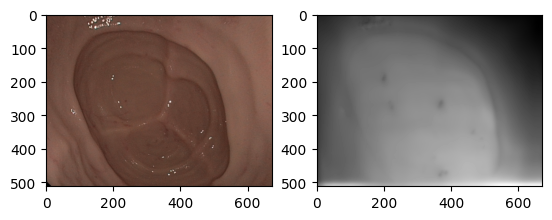

In [19]:
# 推理深度和位姿


disp_net,pose_net = load_model(poseNetPath,dispNetPath)
tgt_img,ref_imgs = load_data(tgt_img_path,ref_imgs_paths)

pose,tgt_depth,ref_depths = run_model(pose_net,disp_net,tgt_img,ref_imgs)

print(pose[0])

print(tgt_depth.max(),tgt_depth.min(),tgt_depth.mean())
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(1,2,1)
plt.imshow(tgt_img.detach().cpu().numpy()[0].transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(tgt_depth[0],cmap='gray')

In [8]:
# 输出真实的位姿
import numpy as np
from scipy.spatial.transform import Rotation

transforms = np.load("/root/autodl-tmp/dataset4SC_Depth/scene1_V/Transforms.npy")

T_tgt,T_refs = transforms[tgt_idx-2534],[ transforms[tgt_idx-2534-1],transforms[tgt_idx-2534+1] ]

pose_refs_gt = [ np.linalg.inv(T_refs[0])@T_tgt, np.linalg.inv(T_refs[1])@T_tgt ]

pose_gt = []
for ppose in pose_refs_gt:
    R,t = ppose[:3,:3],ppose[:3,3]
    rx,ry,rz = Rotation.from_matrix(R).as_euler('xyz')
    tx,ty,tz = t[0],t[1],t[2]
    pp = np.array([tx,ty,tz,rx,ry,rz])[None,...]
    pose_gt.append(pp)


In [9]:
# 变换深度图

np.set_printoptions(suppress=True)

print("=> 0")
print("pose_gt",pose_gt[0])
print("pose",pose[0])
t_gt,t = np.linalg.norm(pose_gt[0][0][:3]),np.linalg.norm(pose[0][0][:3])
print(t_gt,t)
print("t_gt/t",t_gt/t)

print("=> 1")
print("pose_gt",pose_gt[1])
print("pose",pose[1])
t_gt,t = np.linalg.norm(pose_gt[1][0][:3]),np.linalg.norm(pose[1][0][:3])
print(t_gt,t)
print("t_gt/t",t_gt/t)

=> 0
pose_gt [[ 0.74643839 -0.29230976  1.03851184  0.00022189  0.00438876  0.01053601]]
pose [[ 0.00244135  0.0035691   0.01200671 -0.00002068 -0.00034132  0.00028669]]
1.3119154392906034 0.0127616525
t_gt/t 102.80137642144433
=> 1
pose_gt [[ 0.66620103  0.73844769  0.02519845 -0.00857857  0.00209978 -0.01620079]]
pose [[-0.00225183  0.00317975 -0.00435363 -0.00021212 -0.00027515 -0.00080509]]
0.994868717148404 0.005842571
t_gt/t 170.279264411807


### 推理预训练的深度网络

In [9]:
import cv2

# path = "/root/autodl-tmp/SC_Depth_ckpts/pretrainDepth/10-10-19:11/dispnet_model_best.pth.tar"
# path = "/root/autodl-tmp/SC_Depth_ckpts/pretrainDepth/10-13-03:47/dispnet_model_best.pth.tar"
path = "/root/autodl-tmp/SC_Depth_ckpts/pretrainDepth_DenseDepth/10-16-03:11/dispnet_model_best.pth.tar"
# disp_net = load_dispNet(path)
disp_net = load_denseNet(path)




In [20]:
train_transform = custom_transforms.Compose([
    # custom_transforms.RandomHorizontalFlip(),
    # custom_transforms.RandomScaleCrop(),
    custom_transforms.ArrayToTensor()
])

# load data
tgt_img_path = "/root/autodl-tmp/dataset4SC_Depth/scene1_bkp/0002538.jpg"
tgt_img_path = "/root/autodl-tmp/UCL/C_T1_L1_1_resized/FrameBuffer_0258.png"
tgt_img= cv2.imread(tgt_img_path).astype(np.float32)
tgt_img,_ = train_transform([tgt_img],np.identity(3))

tgt_img = tgt_img[0].unsqueeze(0).to(device)
tgt_img_R = torch.concat((tgt_img[0][2:3],tgt_img[0][2:3],tgt_img[0][2:3])).unsqueeze(0).to(device)

with torch.no_grad():
    disp = disp_net(tgt_img)
    disp_R = disp_net(tgt_img_R)
print(disp)

tensor([[[[17.1479, 17.1138, 17.1117,  ..., 15.6608, 15.5576, 15.5057],
          [17.5043, 17.4688, 17.5990,  ..., 16.1120, 15.7986, 15.5061],
          [17.4818, 17.4396, 18.2589,  ..., 16.3306, 16.0249, 16.0214],
          ...,
          [16.7693, 16.7542, 16.7948,  ..., 15.8875, 15.4952, 15.4856],
          [16.8210, 16.8274, 16.7577,  ..., 15.4233, 14.9447, 14.9259],
          [16.6564, 16.6995, 16.6193,  ..., 14.7387, 14.7204, 14.8107]]]],
       device='cuda:0')


77.12536 14.72043


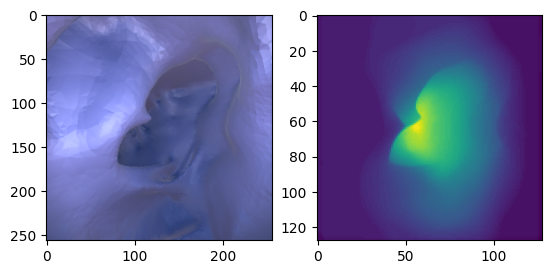

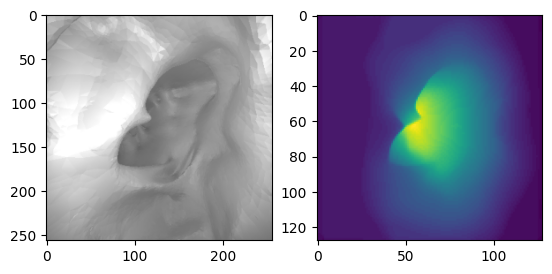

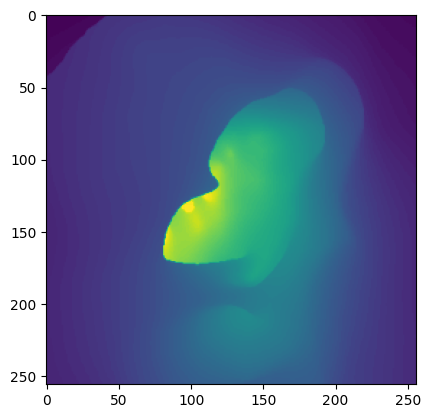

In [22]:
import matplotlib.pyplot as plt

# disp_,disp_R_ = disp[0][0][0].detach().cpu().numpy(), disp_R[0][0][0].detach().cpu().numpy()
disp_,disp_R_ = disp[0][0].detach().cpu().numpy(), disp_R[0][0].detach().cpu().numpy()
# depth,depth_R = 1/disp_, 1/disp_R_
depth,depth_R = disp_, disp_R_
print(depth.max(),depth.min())


plt.figure()
plt.subplot(1,2,1)
plt.imshow(tgt_img.detach().cpu().numpy()[0].transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(depth.astype(np.uint8))

plt.figure()
plt.subplot(1,2,1)
plt.imshow(tgt_img_R.detach().cpu().numpy()[0].transpose((1,2,0)))
plt.subplot(1,2,2)
plt.imshow(depth_R.astype(np.uint8))

plt.figure()
plt.imshow(plt.imread("/root/autodl-tmp/UCL/C_T1_L1_1_resized/Depth_0258.png"))

torch.Size([1, 3, 992, 1152])
torch.Size([1, 3, 496, 576])


/root/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


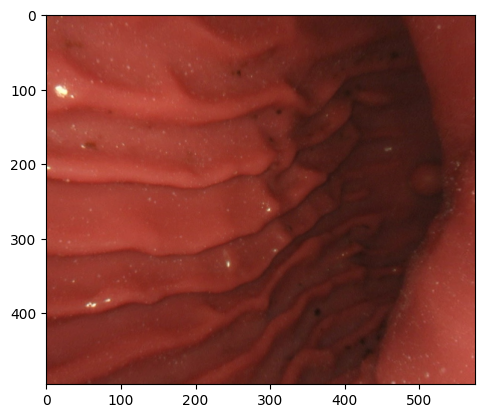

In [30]:
from torch.nn.functional import interpolate

print(tgt_img.shape)
newshape = [tgt_img.shape[0],tgt_img.shape[1],tgt_img.shape[2]/2,tgt_img.shape[3]/2]

tgt_img_ = interpolate(tgt_img,scale_factor=(0.5, 0.5))
# tgt_img_ = tgt_img.resize((1,3,496,576))
print(tgt_img_.shape)
plt.imshow(tgt_img_[0].detach().cpu().numpy().transpose((1,2,0))[...,::-1])